# Algoritmo de Wang Landau

## Imports e Funções Iniciais

In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

Algoritmos de vizinhos e cálculo de energia da atividade anterior do Modelo de Ising

In [18]:
@jit(nopython=True)
def neighbours(N, L):
    """
    Constrói a matriz de vizinhança.
    Assume que há uma "vizinhança circular" como se a rede 
    fosse um toro.
    Adaptação do algoritmo proposto no enunciado
    """
    # Cria uma matriz Nx4
    viz = np.zeros((N,4), dtype=np.longlong)

    # (k,0): vizinho à direita
    # (k,1): vizinho acima
    # (k,2): vizinho à esquerda
    # (k,3): vizinho abaixo]
    for k in range(N):
        # Vizinho à direita (k,0)
        viz[k][0] = k+1
        if (k % L == L-1):
            # Sítio na borda da direita
            viz[k][0] = k+1-L

        # Vizinho acima (k,1)
        viz[k][1] = k+L
        if (k >= N-L):
            # Sítio na borda superior
            viz[k][1] = k+L-N

        # Vizinho à esquerda (k,2)
        viz[k][2] = k-1
        if (k % L == 0):
            # Sítio na borda da esquerda
            viz[k][2] = k+L-1

        # Vizinho abaixo (k,3)
        viz[k][3] = k-L
        if (k < L):
            # Sítio na borda inferior
            viz[k][3] = k+N-L
    return viz

In [19]:
@jit(nopython=True)
def energy_ising(s, viz):
    """
    Calcula a energia da rede Ising usando os vizinhos de cada sítio.
    É importante notar que precisamos apenas dos 
    vizinhos à direita e acima
    """
    E = 0
    N = len(s)
    for i in range(N):
        right = viz[i][0]
        up = viz[i][1]
        h = s[right] + s[up]
        E = E - s[i]*h
    return E

Além desses, temos também algoritmos para achar o mínimo de um vetor, desconsiderando o segundo e o último itens, para escalar a energia com base na equação fornecida no enunciado e para gerar uma configuração aleatória para o sistema

In [20]:
@jit(nopython=True)
def sub_min(H):
    """
    Retorna o mínimo do vetor H, ignorando o segundo e penúltimo itens
    """
    n = len(H)
    menor = H[0]
    for i in range(n):
        if (i == 1 or i == n-2):
            continue
        if (H[i] < menor):
            menor = H[i]
    return menor

In [21]:
@jit(nopython=True)
def energy_scale(N,E):
    """
    Escala os valores de energia para que fiquem entre 0 e N 
    ao invés de -2N até 2N
    """
    E = E+2*N
    E = E/4
    if (int(E) - E > 0):
        print("Energia não inteira pós escala!")
    return int(E)

In [22]:
@jit(nopython=True)
def random_energy_state(N):
    """
    Gera um estado aleatório de energia
    """
    s = []
    # De 0 a N-1
    for i in range(N):
        s.append(np.sign(2*np.random.random()-1))
    s = np.array(s)
    return s

In [23]:
N = 36
s = random_energy_state(N)
viz = neighbours(N,np.sqrt(N))
E = energy_ising(s,viz)
# E = energy_scale(N,E)
# lnG, mmicro = wang_landau(N, E, s)
E

-4.0

## Algoritmo
Implementação do algoritmo de Wang-Landau, tendo como base o algoritmo visto em aula e também o pseudocódigo do enunciado

In [24]:
@jit(nopython=True)
def wang_landau(N, E, s):
    """
    Algoritmo de Wang-Landau para estimativa da densidade de estados g(E)
    """
    # Inicialização arrays, de 0 a N, inclusive
    lnG = np.zeros(N+1, dtype=np.float64)
    H = np.zeros(N+1, dtype=np.int64)
    Hc = np.zeros(N+1, dtype=np.int64)
    mmicro = np.zeros(N+1, dtype=np.float64)
    
    # Variáveis do Loop Principal
    lnf = 1.0
    flat = False
    m = s.sum()
    for i in range(10**7):
        for j in range(N):
            # Escolhe um sítio aleatório
#             rng = np.random.default_rng()
            k = np.random.randint(N)
            
            # Soma sobre os vizinhos de k
            h = 0
            for v_idx in viz[k]:
                h += s[v_idx]
            
            # Energia desse novo estado
            E2 = E + s[k]*h/2
            if (int(E2) - E2 > 0): print("Energia não inteira pós iteração!")
            E2 = int(E2)

            # Economizar algumas exponenciais
            if lnG[E] > lnG[E2]:
                # Faz a troca
                s[k] = -s[k]
                E = E2
                m = m - 2*s[k]
            else:
#                 rng = np.random.default_rng()
                P = np.exp(lnG[E] - lnG[E2])
                if (np.random.random() < P):
                    # Faz a troca
                    s[k] = -s[k]
                    E = E2
                    m = m - 2*s[k]
            H[E] = H[E] + 1
            lnG[E] = lnG[E] + lnf
            ## Usando o abs no mmicro (?)
            mmicro[E] = mmicro[E] + m
            
        if (i % 1000 == 0):
            hmed = np.sum(H)/(N-1)
            hmin = sub_min(H)
            
#             print(f"H={H}, Hc={Hc}, lnf={lnf}")
#             print(f"hmed={round(hmed,2)}, hmin={round(hmin,2)}, "+
#                   f"flat_condition:{round(hmin,2)}>{round(0.8*hmed,2)}, "+
#                   f"i={i}, lnf={lnf}")
            print(round(hmed,2),round(hmin,2),round(hmin,2),
                  round(0.8*hmed,2), i, lnf)

            if (hmin > 0.8*hmed):
                Hc = H.copy()
                H = np.zeros(N+1, dtype=np.int64)
                lnf = lnf/2
        if (lnf < 10**-8):
            break
    mmicro = mmicro/Hc
    lnG0 = lnG[0]
    lnG = lnG - lnG0 + np.log(2)
    return lnG, mmicro

### Rede 6x6

Nesse momento, vamos executar o algoritmo para a rede 6x6, a qual não foi possível de forma exata em tempo hábil na atividade anterior.

In [25]:
N = 36
s = random_energy_state(N)
viz = neighbours(N,np.sqrt(N))
E = energy_ising(s,viz)
E = energy_scale(N,E)
lnG, mmicro = wang_landau(N, E, s)

1.03 0.0 0.0 0.82 0 1.0
1029.6 932.0 932.0 823.68 1000 1.0
1028.57 978.0 978.0 822.86 2000 0.5
1028.57 964.0 964.0 822.86 3000 0.25
1028.57 963.0 963.0 822.86 4000 0.125
1028.57 923.0 923.0 822.86 5000 0.0625
1028.57 968.0 968.0 822.86 6000 0.03125
1028.57 884.0 884.0 822.86 7000 0.015625
1028.57 889.0 889.0 822.86 8000 0.0078125
1028.57 641.0 641.0 822.86 9000 0.00390625
2057.14 1861.0 1861.0 1645.71 10000 0.00390625
1028.57 518.0 518.0 822.86 11000 0.001953125
2057.14 1532.0 1532.0 1645.71 12000 0.001953125
3085.71 2641.0 2641.0 2468.57 13000 0.001953125
1028.57 573.0 573.0 822.86 14000 0.0009765625
2057.14 1384.0 1384.0 1645.71 15000 0.0009765625
3085.71 2394.0 2394.0 2468.57 16000 0.0009765625
4114.29 3558.0 3558.0 3291.43 17000 0.0009765625
1028.57 484.0 484.0 822.86 18000 0.00048828125
2057.14 1532.0 1532.0 1645.71 19000 0.00048828125
3085.71 2797.0 2797.0 2468.57 20000 0.00048828125
1028.57 563.0 563.0 822.86 21000 0.000244140625
2057.14 1553.0 1553.0 1645.71 22000 0.00024414062

É possível comparar os resultados (após tomarmos a exponencial) com os dados obtidos de forma exata manualmente anteriormente.

In [26]:
lnG

array([ 6.93147181e-01, -2.05850510e+03,  4.29915975e+00,  4.98911252e+00,
        7.42057881e+00,  8.72623922e+00,  1.04889996e+01,  1.20045184e+01,
        1.36179501e+01,  1.51833401e+01,  1.67002407e+01,  1.81158441e+01,
        1.94101114e+01,  2.05359288e+01,  2.15197909e+01,  2.22720567e+01,
        2.28499395e+01,  2.32010696e+01,  2.33020651e+01,  2.31867170e+01,
        2.28364093e+01,  2.22817446e+01,  2.14987891e+01,  2.05435968e+01,
        1.94102790e+01,  1.81156173e+01,  1.66799844e+01,  1.51675738e+01,
        1.36128318e+01,  1.19887774e+01,  1.04966173e+01,  8.74042618e+00,
        7.42264989e+00,  5.05104217e+00,  4.34752713e+00, -2.05850510e+03,
        7.53078042e-01])

In [27]:
# Escalando as energias da solução exata para comparação
# Carregando do arquivo
import pickle
# 6x6
L = 6
N = L**2
g6 = None
with open(f"rede{L}x{L}.dict", "rb") as f:
    g6 = pickle.load(f)

# Escalando-os usando a equação 
g6_scaled = np.zeros(N+1, dtype=np.float64)
for key,val in g6.items():
    i = energy_scale(N,key)
    g6_scaled[i] = val

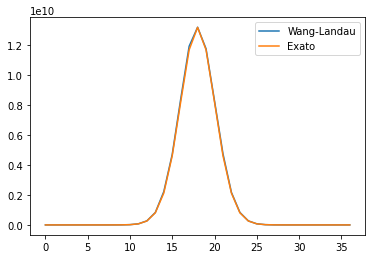

In [28]:
plt.plot(np.exp(lnG))
plt.plot(g6_scaled)
plt.legend(["Wang-Landau","Exato"])

## Propriedades Termodinâmicas
Agora, temos que adaptar os algoritmos que obtêm as propriedades termodinâmicas para utilizar o logaritmo de $g(E)$ ao invés do valor em si.

In [29]:
def media_termo(lnG, N, beta):
    """
    Obtém as propriedades termodinâmicas a uma dada temperatura (com inverso beta),
    dada o logaritmo de energias por configuração (lnG)
    """
    Z = 0
    Em = 0
    Em2 = 0
    
    Emin = energy_scale(N,-2*N)
    Emax = energy_scale(N,2*N)
    
    for E in range(N):
        E1 = E - Emin
        Z = Z + np.exp(lnG[E])*np.exp(-beta*E1)
        
        Em = Em + E1*np.exp(lnG[E])*np.exp(-beta*E1)
        Em2 = Em2 + E1*E1*np.exp(lnG[E])*np.exp(-beta*E1)
    Em = Em/Z
    Em2 = Em2/Z
    
    Z = Z*np.exp(-beta*Emin)
    cv = (beta*beta*(Em2-Em**2))/N
    EpS = (Em + Emin)/N
    return Z, EpS, cv

In [30]:
def energia_livre_spin(Z, N, beta):
    """
    Calcula a energia livre por spin, usando a fórmula do enunciado.
    Note que a função np.log é o logaritmo natural.
    """
    result = N * beta
    result = -1/result
    result = result * np.log(Z)  # np.log é o logaritmo natural
    return result

In [31]:
def entropia_spin(e_spin, e_livre_spin, temp):
    """
    Calcula a entropia livre por spin, usando a fórmula do enunciado.
    Note que utiliza a temperatura e não o inverso dela (beta).
    """
    result = e_spin - e_livre_spin
    result = result / temp
    return result

## Simulações

In [32]:
CREATE_ARRAYS = True

In [33]:
L = 6
N = L**2

if CREATE_ARRAYS:
    s = random_energy_state(N)
    viz = neighbours(N,np.sqrt(N))
    E = energy_ising(s,viz)
    E = energy_scale(N,E)
    lg6, mmicro6 = wang_landau(N, E, s)
    with open(f"wang{L}x{L}.dict", "wb") as f:
        pickle.dump(lg6, f)
    with open(f"mag{L}x{L}.dict", "wb") as f:
        pickle.dump(mmicro6, f)
    print(f"Criado rede {L}x{L}")
else:
    lg6 = None
    mmicro6 = None
    with open(f"wang{L}x{L}.dict", "rb") as f:
        lg6 = pickle.load(f)
    with open(f"mag{L}x{L}.dict", "wb") as f:
        mmicro6 = pickle.load(f)

1.03 0.0 0.0 0.82 0 1.0
1029.6 910.0 910.0 823.68 1000 1.0
1028.57 849.0 849.0 822.86 2000 0.5
1028.57 872.0 872.0 822.86 3000 0.25
1028.57 917.0 917.0 822.86 4000 0.125
1028.57 915.0 915.0 822.86 5000 0.0625
1028.57 896.0 896.0 822.86 6000 0.03125
1028.57 870.0 870.0 822.86 7000 0.015625
1028.57 785.0 785.0 822.86 8000 0.0078125
2057.14 1849.0 1849.0 1645.71 9000 0.0078125
1028.57 804.0 804.0 822.86 10000 0.00390625
2057.14 1633.0 1633.0 1645.71 11000 0.00390625
3085.71 2799.0 2799.0 2468.57 12000 0.00390625
1028.57 781.0 781.0 822.86 13000 0.001953125
2057.14 1844.0 1844.0 1645.71 14000 0.001953125
1028.57 542.0 542.0 822.86 15000 0.0009765625
2057.14 1398.0 1398.0 1645.71 16000 0.0009765625
3085.71 2522.0 2522.0 2468.57 17000 0.0009765625
1028.57 505.0 505.0 822.86 18000 0.00048828125
2057.14 1243.0 1243.0 1645.71 19000 0.00048828125
3085.71 2195.0 2195.0 2468.57 20000 0.00048828125
4114.29 3013.0 3013.0 3291.43 21000 0.00048828125
5142.86 4193.0 4193.0 4114.29 22000 0.00048828125
1

In [ ]:
L = 12
N = L**2

if CREATE_ARRAYS:
    s = random_energy_state(N)
    viz = neighbours(N,np.sqrt(N))
    E = energy_ising(s,viz)
    E = energy_scale(N,E)
    lg12, mmicro12 = wang_landau(N, E, s)
    print("Aqui")
    with open(f"wang{L}x{L}.dict", "wb") as f:
        pickle.dump(lg12, f)
    with open(f"mag{L}x{L}.dict", "wb") as f:
        pickle.dump(mmicro12, f)
    print(f"Criado rede {L}x{L}")
else:
    lg12 = None
    mmicro12 = None
    with open(f"wang{L}x{L}.dict", "rb") as f:
        lg12 = pickle.load(f)
    with open(f"mag{L}x{L}.dict", "wb") as f:
        mmicro12 = pickle.load(f)

In [48]:
L = 18
N = L**2

if CREATE_ARRAYS:
    s = random_energy_state(N)
    viz = neighbours(N,np.sqrt(N))
    E = energy_ising(s,viz)
    E = energy_scale(N,E)
    lg18, mmicro18 = wang_landau(N, E, s)
    with open(f"wang{L}x{L}.dict", "wb") as f:
        pickle.dump(lg18, f)
    with open(f"mag{L}x{L}.dict", "wb") as f:
        pickle.dump(mmicro18, f)
    print(f"Criado rede {L}x{L}")
else:
    lg18 = None
    mmicro18 = None
    with open(f"wang{L}x{L}.dict", "rb") as f:
        lg18 = pickle.load(f)
    with open(f"mag{L}x{L}.dict", "wb") as f:
        mmicro18 = pickle.load(f)

NameError: name 'CREATE_ARRAYS' is not defined

In [79]:
np.exp(lg2)

array([ 2.        ,  0.        , 11.88402237,  0.        ,  1.95488067])

In [71]:
N = 16
s = random_energy_state(N)
viz = neighbours(N,np.sqrt(N))
E = energy_ising(s,viz)
E = energy_scale(N,E)
lg4, mmicro4 = wang_landau(N, E, s)

hmed=1.07, hmin=0, flat_condition:0>0.85, i=0, lnf=1.0
hmed=1067.73, hmin=1038, flat_condition:1038>854.19, i=1000, lnf=1.0
hmed=1066.67, hmin=1036, flat_condition:1036>853.33, i=2000, lnf=0.5
hmed=1066.67, hmin=1047, flat_condition:1047>853.33, i=3000, lnf=0.25
hmed=1066.67, hmin=1026, flat_condition:1026>853.33, i=4000, lnf=0.125
hmed=1066.67, hmin=1023, flat_condition:1023>853.33, i=5000, lnf=0.0625
hmed=1066.67, hmin=1030, flat_condition:1030>853.33, i=6000, lnf=0.03125
hmed=1066.67, hmin=896, flat_condition:896>853.33, i=7000, lnf=0.015625
hmed=1066.67, hmin=979, flat_condition:979>853.33, i=8000, lnf=0.0078125
hmed=1066.67, hmin=967, flat_condition:967>853.33, i=9000, lnf=0.00390625
hmed=1066.67, hmin=808, flat_condition:808>853.33, i=10000, lnf=0.001953125
hmed=2133.33, hmin=1937, flat_condition:1937>1706.67, i=11000, lnf=0.001953125
hmed=1066.67, hmin=845, flat_condition:845>853.33, i=12000, lnf=0.0009765625
hmed=2133.33, hmin=1790, flat_condition:1790>1706.67, i=13000, lnf=0.0

<ipython-input-28-6b9aaef1e1b4>:68: RuntimeWarning: invalid value encountered in true_divide
  mmicro = mmicro/Hc


In [78]:
np.exp(lg4)

array([2.00000000e+00, 0.00000000e+00, 3.35853218e+01, 6.79451340e+01,
       4.13862716e+02, 1.70490081e+03, 6.77959077e+03, 1.30949052e+04,
       2.01693406e+04, 1.36448987e+04, 6.66280603e+03, 1.75141866e+03,
       4.33511066e+02, 6.40067749e+01, 3.22210792e+01, 0.00000000e+00,
       2.00810964e+00])

In [41]:
N = 36
s = random_energy_state(N)
viz = neighbours(N,np.sqrt(N))
E = energy_ising(s,viz)
E = energy_scale(N,E)
lg6, mmicro6 = wang_landau(N, E, s)

hmed=1.0285714285714285, hmin=0, flat_condition:0>0.8228571428571428
hmed=103.88571428571429, hmin=110, flat_condition:110>83.10857142857144
H=[  0   0  51  61  70  81  88  93 122 124 126 132 134 136 140 138 145 146
 152 148 143 146 142 139 128 121  90  84  77  77  76  71  68  63  65   0
  59], Hc=[  0   0  51  61  70  81  88  93 122 124 126 132 134 136 140 138 145 146
 152 148 143 146 142 139 128 121  90  84  77  77  76  71  68  63  65   0
  59]
0.5
hmed=102.85714285714286, hmin=0, flat_condition:0>82.28571428571429
hmed=205.71428571428572, hmin=0, flat_condition:0>164.57142857142858
hmed=308.57142857142856, hmin=1956, flat_condition:1956>246.85714285714286
H=[1956    0   37   11   71   11 6547 2026    3   69   51    0    8   10
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], Hc=[1956    0   37   11   71   11 6547 2026    3   69   51    0    8   10
    0    0    0    0    0    0    0    0    0    0    0    0    0  

hmed=102.85714285714286, hmin=3600, flat_condition:3600>82.28571428571429
H=[3600    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], Hc=[3600    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
9.5367431640625e-07
hmed=102.85714285714286, hmin=3600, flat_condition:3600>82.28571428571429
H=[3600    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], Hc=[3600    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
4.76837158203125e-07
hmed=102.85714285714286, hmin=3600, flat_co

<ipython-input-29-5ccdfabf160d>:67: RuntimeWarning: divide by zero encountered in true_divide
  mmicro = mmicro/Hc
<ipython-input-29-5ccdfabf160d>:67: RuntimeWarning: invalid value encountered in true_divide
  mmicro = mmicro/Hc


In [73]:
lg6, mmicro6 = lnG, mmicro

## Resultados

In [74]:
# Geração dos dados
x_4 = []
y1_4 = []
y2_4 = []
y3_4 = []
y4_4 = []

x_16 = []
y1_16 = []
y2_16 = []
y3_16 = []
y4_16 = []

x_36 = []
y1_36 = []
y2_36 = []
y3_36 = []
y4_36 = []


step = 0.01
t_min = 1
t_max = 5

for temp in np.arange(t_min,t_max,step):
    beta = 1/temp
    
    # 2x2
    N = 4
    Z, EpS, cv = media_termo(lg2, N, beta)
    x_4.append(temp)
    y1_4.append(EpS)  # Energia por spin
    y2_4.append(cv)   # Calor específico
    liv_spin = energia_livre_spin(Z, N, beta)
    y3_4.append(liv_spin)   # Energia livre por spin
    y4_4.append(entropia_spin(EpS, liv_spin, temp))  # Entropia por spin

    # 4x4
    N = 16
    Z, EpS, cv = media_termo(lg4, N, beta)
    x_16.append(temp)
    y1_16.append(EpS)  # Energia por spin
    y2_16.append(cv)   # Calor específico
    liv_spin = energia_livre_spin(Z, N, beta)
    y3_16.append(liv_spin)   # Energia livre por spin
    y4_16.append(entropia_spin(EpS, liv_spin, temp))  # Entropia por spin
    
    # 6x6
    N = 36
    Z, EpS, cv = media_termo(lg6, N, beta)
    x_36.append(temp)
    y1_36.append(EpS)  # Energia por spin
    y2_36.append(cv)   # Calor específico
    liv_spin = energia_livre_spin(Z, N, beta)
    y3_36.append(liv_spin)   # Energia livre por spin
    y4_36.append(entropia_spin(EpS, liv_spin, temp))  # Entropia por spin

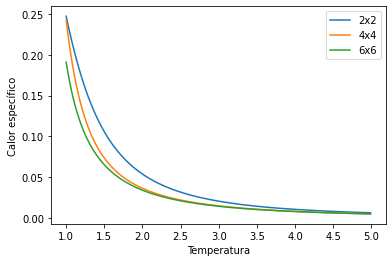

In [75]:
# Plot Calor Específico
plt.plot(x_4 ,y2_4 )
plt.plot(x_16,y2_16)
plt.plot(x_36,y2_36)
plt.ylabel("Calor específico")
plt.xlabel("Temperatura")
plt.legend(["2x2","4x4","6x6"])
plt.show()

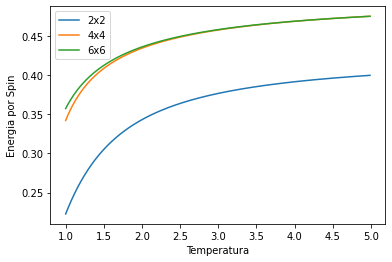

In [76]:
# Plot Energia por Spin
plt.plot(x_4 ,y1_4 )
plt.plot(x_16,y1_16)
plt.plot(x_36,y1_36)
plt.ylabel("Energia por Spin")
plt.xlabel("Temperatura")
plt.legend(["2x2","4x4","6x6"])
plt.show()

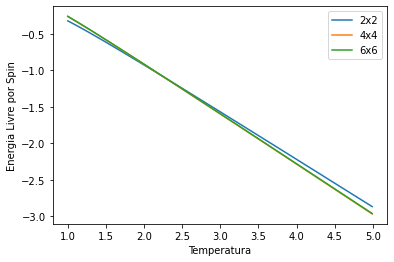

In [77]:
# Plot Energia Livre por Spin
plt.plot(x_4 ,y3_4 )
plt.plot(x_16,y3_16)
plt.plot(x_36,y3_36)
plt.ylabel("Energia Livre por Spin")
plt.xlabel("Temperatura")
plt.legend(["2x2","4x4","6x6"])
plt.show()

## Médias Termdinâmicas Exatas

In [2]:
import pickle

# Carregar do arquivo
# 2x2
L = 2
N = L**2
g2 = None
with open(f"rede{L}x{L}.dict", "rb") as f:
    g2 = pickle.load(f)

# 4x4
L = 4
N = L**2
g4 = None
with open(f"rede{L}x{L}.dict", "rb") as f:
    g4 = pickle.load(f)

# 6x6
L = 6
N = L**2
g6 = None
with open(f"rede{L}x{L}.dict", "rb") as f:
    g6 = pickle.load(f)

In [3]:
print(g2)
print(g4)
print(g6)

{-8: 2, -4: 0, 0: 12, 4: 0, 8: 2}
{-32: 2, -28: 0, -24: 32, -20: 64, -16: 424, -12: 1728, -8: 6688, -4: 13568, 0: 20524, 4: 13568, 8: 6688, 12: 1728, 16: 424, 20: 64, 24: 32, 28: 0, 32: 2}
{-72: 2, -68: 0, -64: 72, -60: 144, -56: 1620, -52: 6048, -48: 35148, -44: 159840, -40: 804078, -36: 3846576, -32: 17569080, -28: 71789328, -24: 260434986, -20: 808871328, -16: 2122173684, -12: 4616013408, -8: 8196905106, -4: 11674988208, 0: 13172279424, 4: 11674988208, 8: 8196905106, 12: 4616013408, 16: 2122173684, 20: 808871328, 24: 260434986, 28: 71789328, 32: 17569080, 36: 3846576, 40: 804078, 44: 159840, 48: 35148, 52: 6048, 56: 1620, 60: 144, 64: 72, 68: 0, 72: 2}


In [ ]:
# Normalize g2 energy
g2_escaled

In [8]:
lg2 = np.log(g2, where=g2>0)
lg2

TypeError: '>' not supported between instances of 'dict' and 'int'

In [3]:
%load exact_ising.py neighbours
import numpy as np

def neighbours(N, L):
    """
    Constrói a matriz de vizinhança.
    Assume que há uma "vizinhança circular" como se a rede 
    fosse um toro.
    Adaptação do algoritmo proposto no enunciado
    """
    # Cria uma matriz Nx4
    viz = np.zeros((N,4), dtype=np.longlong)

    # (k,0): vizinho à direita
    # (k,1): vizinho acima
    # (k,2): vizinho à esquerda
    # (k,3): vizinho abaixo]
    for k in range(N):
        # Vizinho à direita (k,0)
        viz[k][0] = k+1
        if (k % L == L-1):
            # Sítio na borda da direita
            viz[k][0] = k+1-L

        # Vizinho acima (k,1)
        viz[k][1] = k+L
        if (k >= N-L):
            # Sítio na borda superior
            viz[k][1] = k+L-N

        # Vizinho à esquerda (k,2)
        viz[k][2] = k-1
        if (k % L == 0):
            # Sítio na borda da esquerda
            viz[k][2] = k+L-1

        # Vizinho abaixo (k,3)
        viz[k][3] = k-L
        if (k < L):
            # Sítio na borda inferior
            viz[k][3] = k+N-L
    return viz

def energy_ising(s, viz):
    """
    Calcula a energia da rede Ising usando os vizinhos de cada sítio.
    É importante notar que precisamos apenas dos 
    vizinhos à direita e acima
    """
    E = 0
    N = len(s)
    for i in range(N):
        right = viz[i][0]
        up = viz[i][1]
        h = s[right] + s[up]
        E = E - s[i]*h
    return E

def energy_flip(Ei, sf, i, viz):
    """
    Calcula a energia da nova configuração sf e 
    qual sítio i foi flipado.
    """
    # Soma os spins dos 4 vizinhos
    Ssj = 0
    for k in range(4):
        idx_viz = viz[i,k]
        Ssj += sf[idx_viz]
    
    # Usa a fórmula do enunciado
    Ef = Ei - 2*sf[i]*Ssj
    return Ef

def gray_flip(tau, N):
    k = tau[0]
    if (k > N):
        print("Return")
        return
    tau[k-1] = tau[k]
    tau[k] = k+1
    if (k != 1):
        tau[0] = 1
    return k,tau

def qtd_energias(N):
    """
    Calcula quais níveis de energia possíveis.
    Retorna também um array com eles.
    Sabe-se que vão de -2N até 2N, inclusive, saltando de 4 em 4
    """
    g = []
    
    i = -2*N
    counter = 1
    g.append(i)
    while(i < 2*N):
        i += 4
        counter += 1
        g.append(i)
    return counter, g

def enumera_ising(N, viz):
    """
    Obtém g(E) enumerando as configurações com auxílio 
    do código gray
    """
    qtd, energs = qtd_energias(N)
    g = {}
    for e in energs:
        g[e] = np.longlong(0)
    s = [-1 for i in range(N)]
    s = np.array(s, dtype=np.longlong)
    tau = [i for i in range(1,N+2)]
    
    E = -2*N
    g[E] = 2
    
    for i in range(1, 2**(N-1)):
        k, tau = gray_flip(tau, N)
        h = 0
        for v in viz[k]:
            h += s[v]
        E += 2*s[k]*h
        g[E] += 2
        s[k] = -s[k]
        print(f"{i/(2**(N-1)) * 100:.5f}%", end="\r")
    return g

g = enumera_ising(36, neighbours(36,6))
np.save(f"PyPy_rede6x6.npy", g)

ValueError: 'exact_ising.py neighbours' was not found in history, as a file, url, nor in the user namespace.